# Notebook 5: use corrected activity images and dose point kernel (Monte Carlo, provided) to generate dose rate image using two methods
- sequential method
- cloning method (approximation scheme)
- inputs: dose point kernel (simulated separately), parameters, folder of aligned and corrected actiity images
- output: dose-rate image of central slice of the measured volume.

This is the final step in the iQID-DPK calculation scheme (produce dose-rate images). Everything that comes after is analysis of this data, for example:
- comparison to biodistribution study
- comparison to histological (H&E) information
- calculation of organ toxicity and tumor kill efficacy

In [1]:
cd ..

C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas


In [2]:
import os
from pathlib import Path
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy.ndimage import convolve

%load_ext autoreload
%autoreload 2
from iqid import helper as iq
from iqid import process_object as po
from iqid import align
from iqid import dpk

pltmap = iq.set_plot_parms()

In [3]:
def plot(imslice):
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(imslice, cmap='inferno')
    ax.axis('off')
    cbar = iq.nice_colorbar(im)
    cbar.set_label('Absorbed dose (mGy/h)')
    plt.tight_layout()
    plt.show()
    plt.close()

## Parameters and corrections

In [4]:
datdir = os.path.join("data_sample", "2_sample")
imdir =  os.path.join(datdir, "robin_test", "mBq_corrected")

In [5]:
thalf_ac225 = 9.92 * 24 * 3600 # s; updated value (2019) from NNDC for Ac-225
thalf_at217 = 32.3 * 1e-3 # s; At-217 is the fastest decay product and on the order of iQID FR)
framerate = 25 # fps of the data collection
px_mm = 1/(80/2048) # 39.0 um effective pixel size
zthick = 10 # um, slice thickness
num_slices = 10 # arbitrary number with which to pad on either side for cloning method
subpx = 1 # factor used to subpixelate (interpolate) the listmode data: 1 = no interpolation

In [6]:
# decay correction times
d, h, m = np.genfromtxt(os.path.join(datdir, 'correction_times.csv'),
                                  delimiter=',',
                                  skip_header=1,
                                  usecols=(7, 8, 9),
                                  unpack=True)

s_corr = 24 * 3600 * d + 3600 * h + 60 * m

## Load dose kernel

In [7]:
kernel_loc = os.path.join(datdir, 'ac225_alphas_kernel_1e6.txt')

In [8]:
%%time

# Load in the Geant4 kernel and average radially.
dose_kernel = np.genfromtxt(kernel_loc, skip_header=0, delimiter=' ')
dose_kernel = dose_kernel.reshape((181, 181, 181))/1e6
radial_kernel = dpk.radial_avg_kernel(dose_kernel, mode='whole')

# Pad the kernel up to integer multiples of the voxel size.
um_per_px = 1/px_mm * 1e3 / subpx
padded_kernel = dpk.pad_kernel_to_vsize(radial_kernel,
                                        vox_xy=um_per_px,
                                        slice_z=zthick)

# Bin the kernel down to match the iQID image resolution.
d, m, n = padded_kernel.shape
binned_kernel = iq.bin_ndarray(padded_kernel,
                                    (int(np.round(d/zthick)),
                                    int(np.round(m/um_per_px)),
                                    int(np.round(n/um_per_px))))

vox_vol_m = (um_per_px * 1e-6)**2 * (zthick * 1e-6)
mgy_kernel = dpk.mev_to_mgy(binned_kernel, vox_vol_m)

print(mgy_kernel.shape)

# Efficiency and FrameRate corrections
eff_4pi = 4.25/4.32
eff_2pi = 0.5*eff_4pi
efficiency_factor = 1/eff_2pi
time_snapshot = 1  # second

fr_corr, _, _ = dpk.fr_corr_ac(framerate)
print(fr_corr)

(19, 5, 5)
1.0895600769388674
CPU times: total: 17.5 s
Wall time: 17.5 s


# D1M1

### Sequential method

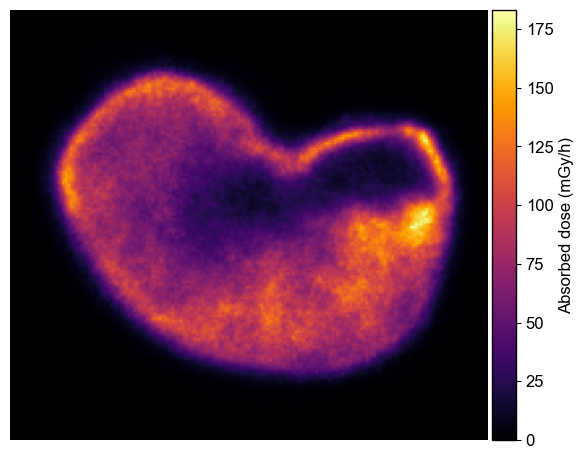

CPU times: total: 359 ms
Wall time: 349 ms


In [9]:
%%time

astack_mBq = align.assemble_stack(imdir, fformat='tif', pad=False)
events = astack_mBq * efficiency_factor * fr_corr * time_snapshot * 1e-3 # convert mBq > Bq
mgy_per_hr = convolve(events, mgy_kernel) * 60 * 60
central_slice = mgy_per_hr[len(mgy_per_hr)//2,:,:]
plot(central_slice)


# save in data folder
# newdir = os.path.join(imdir, '..', 'doseinfo')
# Path(newdir).mkdir(parents=True, exist_ok=True)
# io.imsave(os.path.join(newdir, 'mgy_per_h_sequential.tif'), central_slice, 
#           plugin='tifffile', photometric='minisblack')

In [10]:
# hold on to the central slice for comparison
mgyh_seq = np.copy(central_slice)

### Cloning method

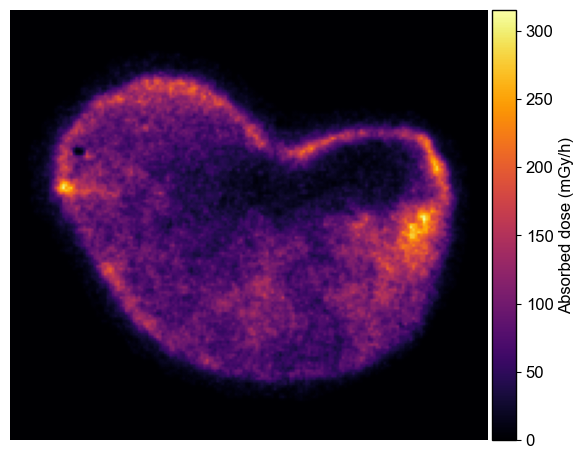

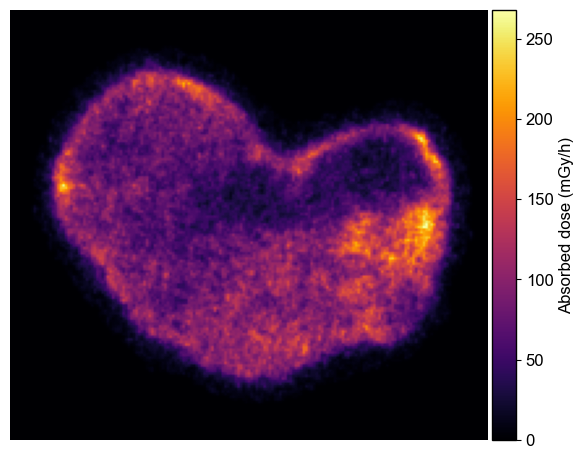

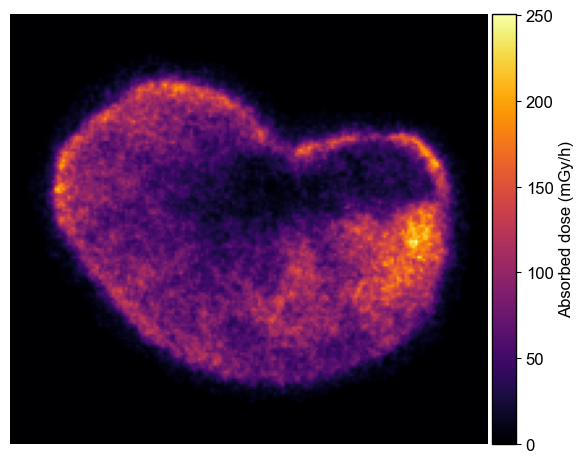

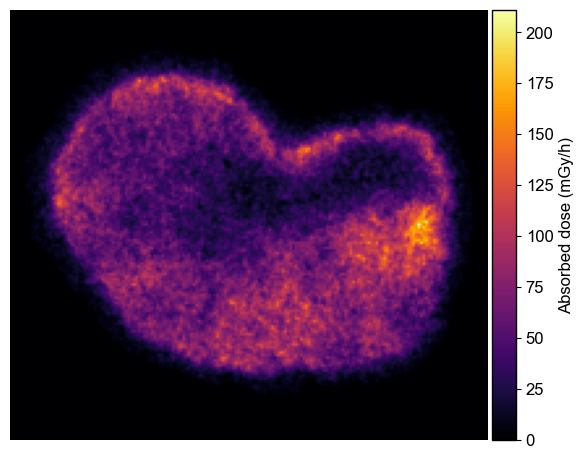

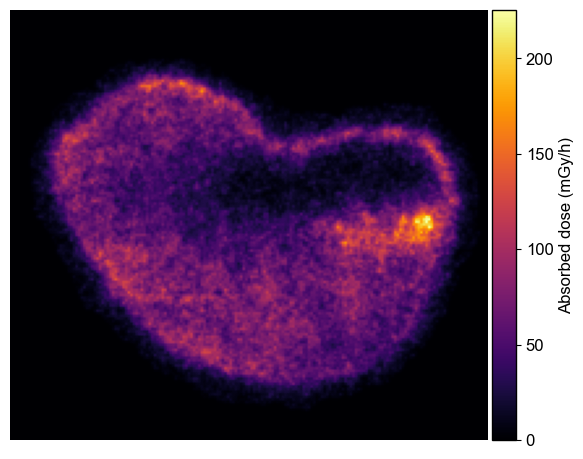

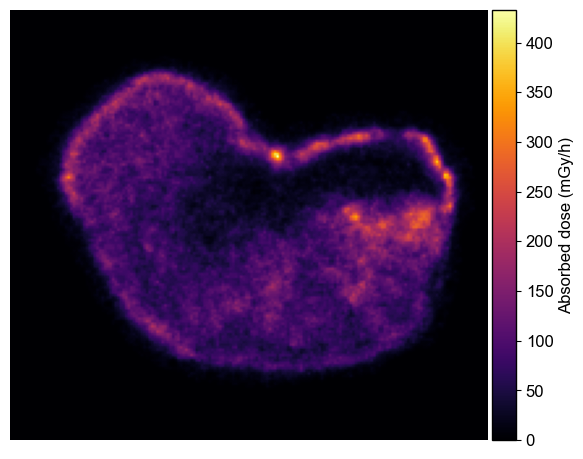

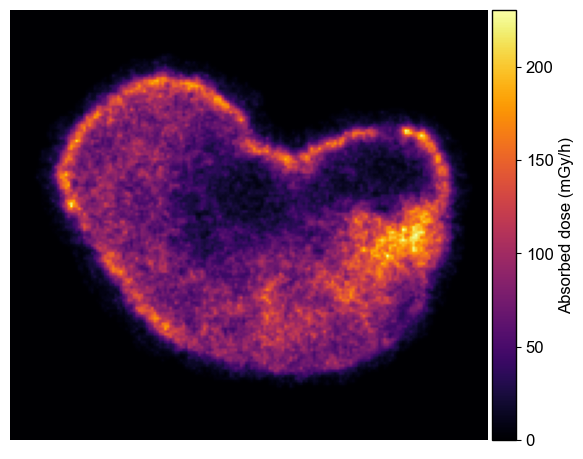

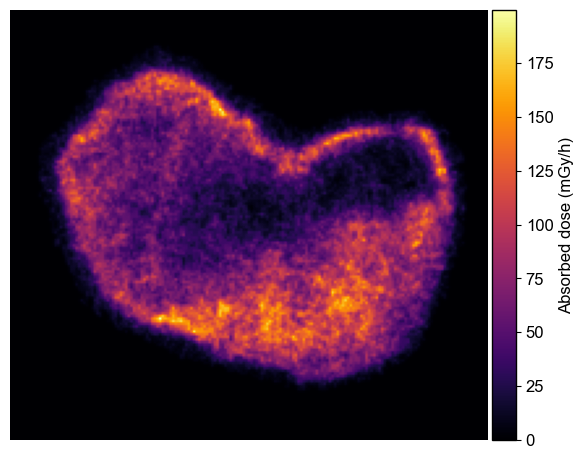

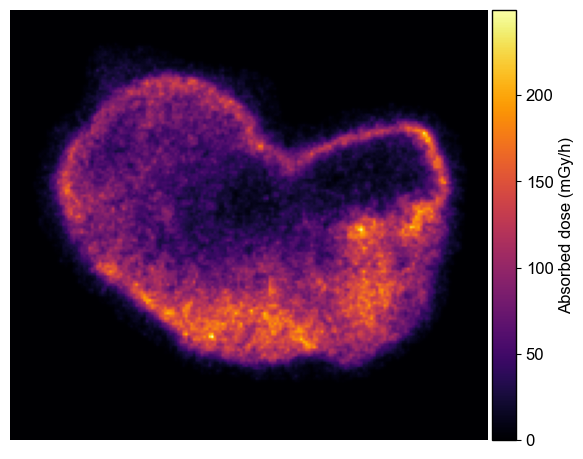

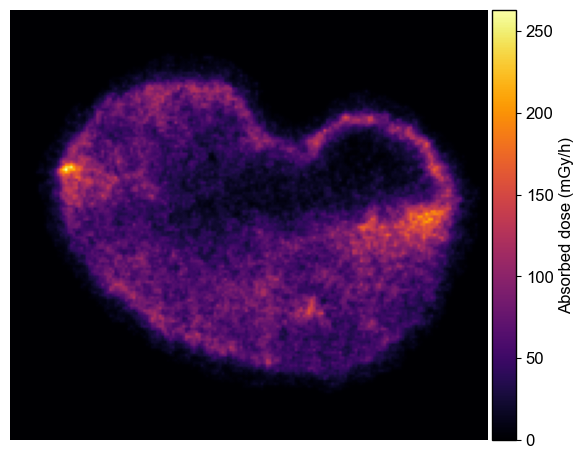

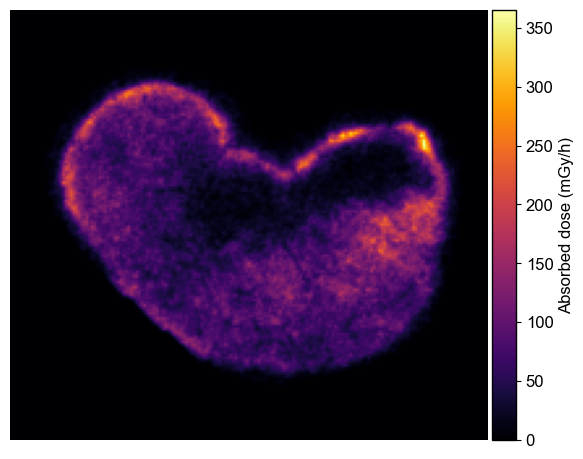

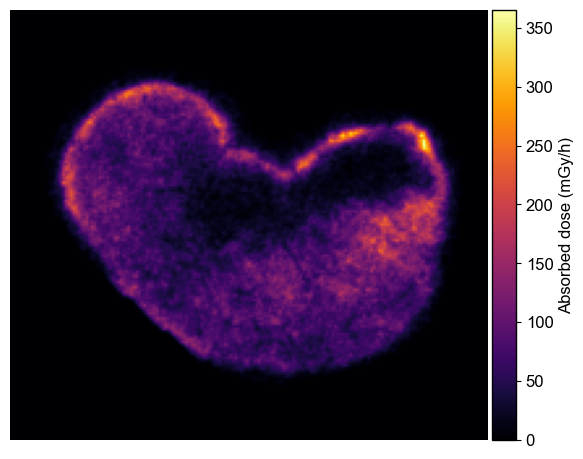

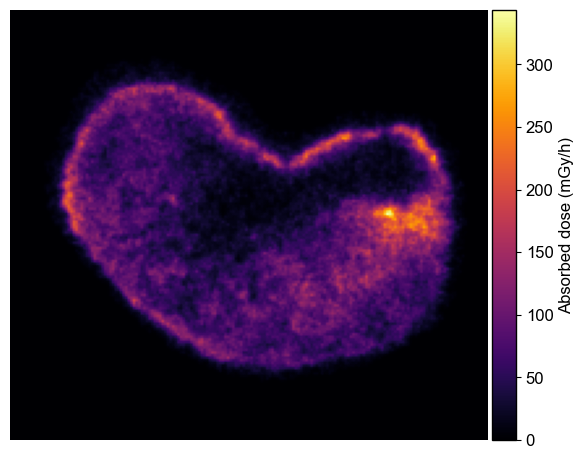

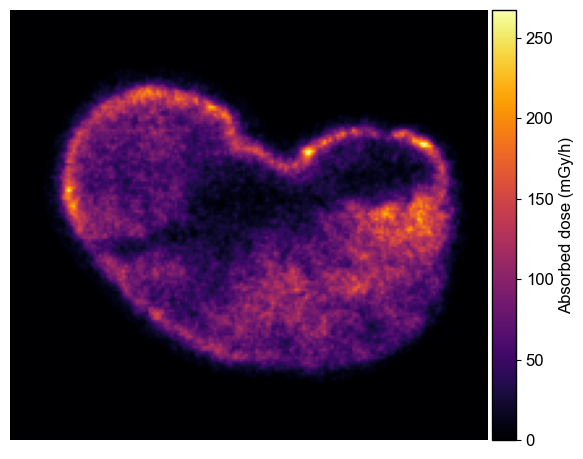

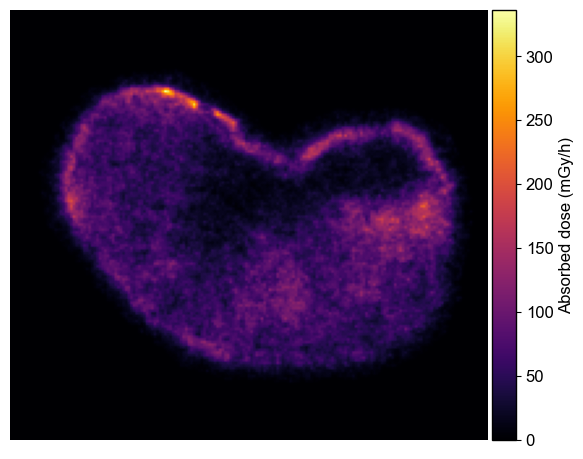

CPU times: total: 3.89 s
Wall time: 3.9 s


In [11]:
%%time

clone_stack = np.zeros_like(events)
for i in range(len(events)):
    base_image = np.copy(events[i])
    duped_stack = np.repeat(base_image[np.newaxis, :, :], num_slices, axis=0)
    mgy_per_hr = convolve(duped_stack, mgy_kernel) * 60 * 60
    clone_stack[i] = mgy_per_hr[len(mgy_per_hr)//2,:,:]
    
    plot(clone_stack[i])
    # plt.savefig(os.path.join(newdir, 'cloning_dose_preview_{}.png'.format(i)))

    # io.imsave(os.path.join(newdir, 'mgy_per_h_cloning_{}.tif'.format(i)), clone_stack[i], 
    #           plugin='tifffile', photometric='minisblack')

Mean % err (compared to image 1): -7.05 %
Max % err (compared to image 1): 9.03 %


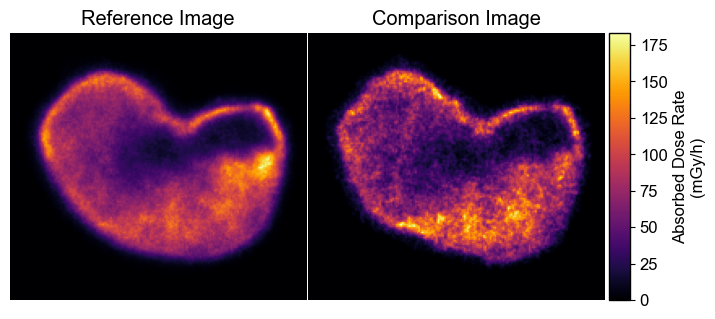

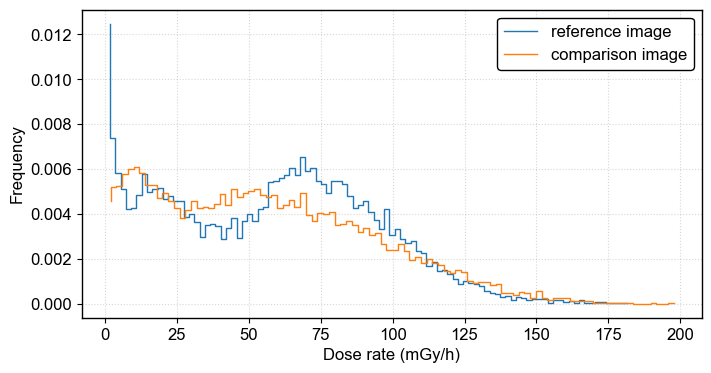

In [12]:
# for this set, middle two are the same due to duplicating to remove torn slice in preprocessing
iq.compare_metrics(mgyh_seq, clone_stack[len(clone_stack)//2])